In [31]:
import shap
import numpy as np
import scipy
from utils import get_permutations
from dataset_manager import MovieLensManager

In [33]:
kg_manager = MovieLensManager()
kg_manager.llm_df

,source_id,target_id,id_x,id_y,prompt_feature_title,prompt_feature_genres,labels,split,split_x,split_y,_merge,prompt
0,0,0,0,0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy...",1,train,NaN,NaN,NaN,"0[SEP]0[SEP]Toy Story (1995)[SEP]['Adventure',..."
1,0,0,0,0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy...",1,val,NaN,NaN,NaN,"0[SEP]0[SEP]Toy Story (1995)[SEP]['Adventure',..."
2,0,2,0,2,Grumpier Old Men (1995),"['Comedy', 'Romance']",1,test,NaN,NaN,NaN,0[SEP]2[SEP]Grumpier Old Men (1995)[SEP]['Come...
3,0,5,0,5,Heat (1995),"['Action', 'Crime', 'Thriller']",1,train,NaN,NaN,NaN,"0[SEP]5[SEP]Heat (1995)[SEP]['Action', 'Crime'..."
4,0,5,0,5,Heat (1995),"['Action', 'Crime', 'Thriller']",1,test,NaN,NaN,NaN,"0[SEP]5[SEP]Heat (1995)[SEP]['Action', 'Crime'..."
...,...,...,...,...,...,...,...,...,...,...,...,...
147217,609,9462,609,9462,Get Out (2017),['Horror'],1,test,NaN,NaN,NaN,609[SEP]9462[SEP]Get Out (2017)[SEP]['Horror']
147218,609,9463,609,9463,Logan (2017),"['Action', 'Sci-Fi']",1,train,NaN,NaN,NaN,"609[SEP]9463[SEP]Logan (2017)[SEP]['Action', '..."
147219,609,9463,609,9463,Logan (2017),"['Action', 'Sci-Fi']",1,val,NaN,NaN,NaN,"609[SEP]9463[SEP]Logan (2017)[SEP]['Action', '..."
147220,609,9503,609,9503,The Fate of the Furious (2017),"['Action', 'Crime', 'Drama', 'Thriller']",1,train,NaN,NaN,NaN,609[SEP]9503[SEP]The Fate of the Furious (2017...


In [41]:
input_tokens = [
    [
        "[CLS]",
        row["source_id"],
        row["target_id"],
        row["prompt_feature_title"],
        row["prompt_feature_genres"],
        "[SEP]",
    ]
    for _, row in kg_manager.llm_df.iterrows()
]

In [42]:
sep_list = ["cls", "user_id", "movie_id", "title", "genres", "sep"]
permutations = get_permutations(sep_list)
sep_dict = dict()
sep_dict_permutations = dict()
for idx, permutation in enumerate(
    permutations
):  # for {"cls", "user_id"} in [{"cls", "user_id"}, ...]
    for elem in permutation:  # for 'cls' in {"cls", "user_id"}
        if elem not in sep_dict:
            sep_dict[elem] = []  # sep_dict['cls] = []
        sep_dict[elem].append(
            (permutation, idx)
        )  # sep_dict['cls] = [{"cls"}, {"cls", "user_id"}]
    sep_dict_permutations[permutation] = idx

In [74]:
logits = np.zeros((len(input_tokens), len(permutations), 2))
for permutation in range(len(permutations)):
    lower_boundary = np.random.random()
    upper_boundary = np.random.uniform(low=lower_boundary)
    logits[:, permutation, 1] = np.random.uniform(
        size=len(input_tokens), low=lower_boundary, high=upper_boundary
    )
logits.shape

(147222, 64, 2)

In [75]:
shap_values = []
for elem in sep_list:
    shap_value = np.zeros(len(logits))
    for s in sep_dict[elem]:
        s_mutable = set(s[0])
        s_mutable.remove(elem)
        s_imutable = frozenset(s_mutable)
        index_with_i = sep_dict_permutations[s_imutable]
        shap_value += (
            logits[:, index_with_i, 1] - logits[:, s[1], 1]
        ) / scipy.special.binom(len(permutations) - 1, len(s[0]))
    shap_value = shap_value / len(permutations)
    shap_values.append(shap_value)
shap_values = np.stack(shap_values, axis=1)
base_value = np.mean(logits[:, :, 1], axis=1)
shap_values.shape, base_value.shape, len(input_tokens)

((147222, 6), (147222,), 147222)

In [76]:
explainer = shap.Explanation(
    values=shap_values,
    data=input_tokens,
    feature_names=sep_list,
)

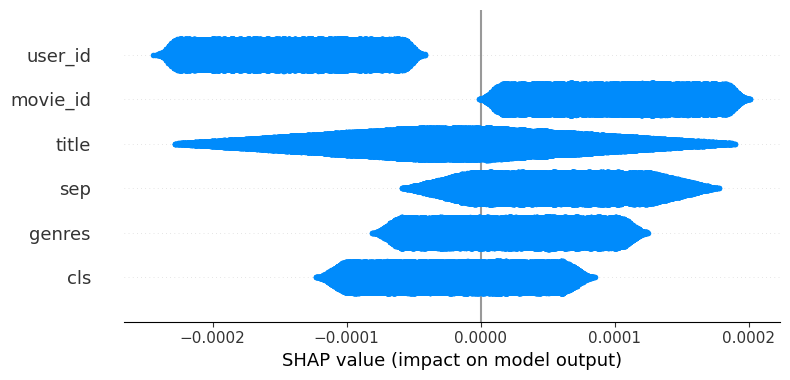

In [77]:
shap.summary_plot(
    explainer.values, explainer.data, feature_names=explainer.feature_names
)

In [80]:
shap.force_plot(
    explainer[0].values,
    explainer[0].data,
    feature_names=explainer.feature_names,
)

TypeError: The shap_values arg looks multi output, try `shap_values[i]` instead.